In [1]:
pip install pydssp

Note: you may need to restart the kernel to use updated packages.


In [2]:
import wget
import numpy as np
import os
#download an example pdb file
url = 'https://files.rcsb.org/download/1EEI.pdb'
filename = wget.download(url)


In [3]:
import pandas as pd
aaproperties = pd.read_csv('./aaindex1.csv', header=0)

aaproperties.drop( [ 'description' , 'reference'  ], axis=1, inplace=True)
print(aaproperties.columns)


#one hot encoding
onehot= np.fill_diagonal(np.zeros((20,20)), 1)

#append to the dataframe
aaproperties = pd.concat([aaproperties, pd.DataFrame(onehot) ], axis=1)


print(aaproperties.head())


Index(['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F',
       'P', 'S', 'T', 'W', 'Y', 'V'],
      dtype='object')
      A     R     N     D     C     Q     E     G     H     I     L     K  \
0  4.35  4.38  4.75  4.76  4.65  4.37  4.29  3.97  4.63  3.95  4.17  4.36   
1  0.61  0.60  0.06  0.46  1.07  0.00  0.47  0.07  0.61  2.22  1.53  1.15   
2  1.18  0.20  0.23  0.05  1.89  0.72  0.11  0.49  0.31  1.45  3.23  0.06   
3  1.56  0.45  0.27  0.14  1.23  0.51  0.23  0.62  0.29  1.67  2.93  0.15   
4  1.00  0.52  0.35  0.44  0.06  0.44  0.73  0.35  0.60  0.73  1.00  0.60   

      M     F     P     S     T     W     Y     V  
0  4.52  4.66  4.44  4.50  4.35  4.70  4.60  3.95  
1  1.18  2.02  1.95  0.05  0.05  2.65  1.88  1.32  
2  2.67  1.96  0.76  0.97  0.84  0.77  0.39  1.08  
3  2.96  2.03  0.76  0.81  0.91  1.08  0.68  1.14  
4  1.00  0.60  0.06  0.35  0.44  0.73  0.44  0.82  


In [7]:
pip install prody

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 9.0 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 8.9 MB/s eta 0:00:00:00:0100:01
  Created wheel for prody: filename=ProDy-2.4.1-cp311-cp311-linux_x86_64.whl size=22152078 sha256=906cdb5a009437a51e7cb276730dc1ad5650b17648336b32de435df038dfd4bc
  Stored in directory: /home/cacutskid/.cache/pip/wheels/6c/b1/85/e303653053b48dfb79b141ab7628dc80f0b7e345bafb881fc9
Successfully built prody
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: biopython
    Found existing installation: biopython 1.81
    Uninstalling biopython-1.81:
      Successfull

In [12]:
from Bio import PDB
import warnings
from matplotlib import pyplot as plt
import numpy as np
import torch
import pydssp
from Bio.PDB import PDBParser   
import numpy as np
filename = './1eei.pdb'
    
def read_pdb(filename):
    #silence all warnings
    warnings.filterwarnings('ignore')

    with warnings.catch_warnings():        
        parser = PDB.PDBParser()
        structure = parser.get_structure(filename, filename)
        chains = [ c for c in structure.get_chains()]
        return chains

#return the phi, psi, and omega angles for each residue in a chain
def get_angles(chain):

    phi_psi_angles = []

    chain = [ r for r in chain if PDB.is_aa(r)]
    #sliding window of 3 residues
    polypeptides = [ chain[i:i+3] for i in range(len(chain)) if len(chain[i:i+4]) >= 3]
    #translate to single letter code
    print(polypeptides)


    for poly_index, poly in enumerate(polypeptides):
        phi = None
        psi = None

        if len(poly) >= 3:
            c_minus_1 = poly[len(poly) - 3]["C"].get_vector()
            n = poly[len(poly) - 2]["N"].get_vector()
            ca = poly[len(poly) - 2]["CA"].get_vector()
            c = poly[len(poly) - 2]["C"].get_vector()

            # Calculate phi angle
            phi = PDB.calc_dihedral(c_minus_1, n, ca, c)
            n = poly[len(poly) - 2]["N"].get_vector()
            ca = poly[len(poly) - 2]["CA"].get_vector()
            c = poly[len(poly) - 2]["C"].get_vector()
            n_plus_1 = poly[len(poly) - 1]["N"].get_vector()

            # Calculate psi angle
            psi = PDB.calc_dihedral(n, ca, c, n_plus_1)
        residue = poly[0]
        residue_id = residue.get_full_id()

        phi_psi_angles.append({
            "Chain": residue_id[2],
            "Residue_Number": residue_id[3][1],
            "Residue_Name": residue.get_resname(),
            #translate 3 letter to 1 letter code
            "single_letter_code": PDB.Polypeptide.three_to_one(residue.get_resname()),
            "Phi_Angle": phi,
            "Psi_Angle": psi
        })
    #transform phi and psi angles into a dataframe
    phi_psi_angles = pd.DataFrame(phi_psi_angles)
    #transform the residue names into single letter code
    return phi_psi_angles    

def get_contact_points(chain, distance):
    contact_mat = np.zeros((len(chain), len(chain)))
    for i,r1 in enumerate(chain):
        for j,r2 in enumerate(chain):
            if i< j:
                if 'CA' in r1 and 'CA' in r2:
                    if r1['CA'] - r2['CA'] < distance:
                        contact_mat[i,j] =  r1['CA'] - r2['CA']
    contact_mat = contact_mat + contact_mat.T
    return contact_mat


def ret_hbonds(chain , verbose = False):
    #loop through all atoms in a structure
    struct = PDBParser().get_structure('1eei', filename)

    #get the number of atoms in the chain
    #create a numpy array of zeros with the shape of (1, length, atoms, xyz)
    output = np.zeros((1, len(chain), len(typeindex), 3 ))
    for c, res in enumerate(chain):
        atoms = res.get_atoms()
        for at,atom in enumerate(atoms):
            if atom.get_name() in typeindex:
                output[ 0, c ,  typeindex[atom.get_name()] , : ]  = atom.get_coord()
    output = torch.tensor(output)
    if verbose:
        print(output.shape)
    mat =  pydssp.get_hbond_map(output[0])
    return mat


#add the amino acid properties to the angles dataframe
#one hot encode the amino acid properties


def add_aaproperties(angles, aaproperties):
    nodeprops = angles.merge(aaproperties, left_on='single_letter_code', right_index=True, how='left')
    nodeprops = nodeprops.dropna()

    #generate 1 hot encoding for each amino acid

    one_hot = pd.get_dummies(nodeprops['single_letter_code'])
    nodeprops = nodeprops.join(one_hot)
    nodeprops = nodeprops.drop(columns=['single_letter_code'])

    return nodeprops



In [17]:
from prody import *
from pylab import *

def anm_analysis(filename):
    prot = parsePDB( filename)
    calphas2 = prot.select('calpha')
    anm = ANM('ANM analysis')
    anm.buildHessian(calphas2)
    anm.calcModes()

    cov = anm.getCovariance()

    return eigvals, eigvecs, cov

eigvals, eigvecs, cov = anm_analysis(filename)
print(cov.shape)




@> 4630 atoms and 1 coordinate set(s) were parsed in 0.37s.
@> Hessian was built in 0.56s.
@> 20 modes were calculated in 1.57s.


(1545, 1545)


In [ ]:
%matplotlib inline
prody.showProtein(prot)
prody.checkUpdates()
import py3Dmol
prody.showProtein(prot)

In [5]:
#create features from a chain

def create_features(chain, aaproperties, verbose = False):
    angles = get_angles(chain)
    angles = add_aaproperties(angles, aaproperties)
    angles = angles.dropna()
    angles = angles.reset_index(drop=True)
    angles = angles.drop(['Residue_Name', 'single_letter_code'], axis=1)
    angles = angles.set_index(['Chain', 'Residue_Number'])
    angles = angles.sort_index()
    angles = angles.dropna()
    angles = angles.reset_index()
    angles = angles.drop(['Chain', 'Residue_Number'], axis=1)
    angles = angles.values
    angles = angles.astype('float32')
    angles = torch.tensor(angles)
    
    if verbose:
        print(angles.shape)
    backbone
    contact_points
    hbond_mat
    
    
    return angles


In [6]:
adjacency_tensor = np.stack([backbone, contact_points, hbond_mat], axis=0)
print( adjacency_tensor.shape)

NameError: name 'backbone' is not defined

MultiGraph with 181 nodes and 8062 edges


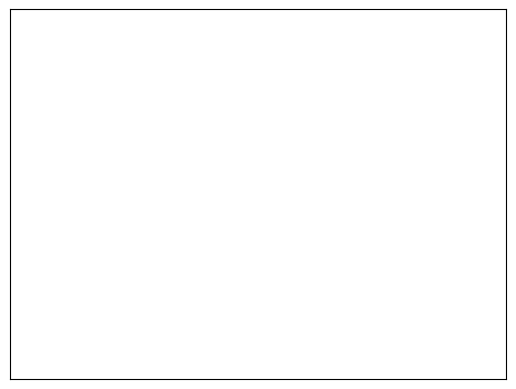

In [ ]:
import networkx as nx
#transform the contact matrices into a networkx multigraph 
import colour 

def tensor_to_multigraph(adjacency_tensor):
    # Initialize a MultiGraph
    G = nx.MultiGraph()
    num_nodes = adjacency_tensor.shape[1]
    G.add_nodes_from(range(num_nodes))
    colors = [ c.hex_l for c in  colour.Color('red').range_to(colour.Color('green'), adjacency_tensor.shape[0]) ]
    # Iterate through the adjacency matrices in the tensor
    for i, adj_matrix in enumerate(adjacency_tensor):
        # Add nodes to the MultiGraph
        # Iterate through the rows and columns of the adjacency matrix to add edges
        for row in range(num_nodes):
            for col in range(num_nodes):
                if adjacency_tensor[i,row, col] != 0:
                    # Add an edge with weight (if needed) to the MultiGraph
                    G.add_edge(row, col, weight=adjacency_tensor[i,row, col] , color = colors[i],  layer= i )
    return G

def draw_graph(G , adjacency_tensor ):
    # Get the color of each edge
    edge_colors = [e[2]['color'] for e in G.edges(data=True)]
    # Get the weight of each edge
    edge_weights = [e[2]['weight'] for e in G.edges(data=True)]

    # Get the positions of each node in the graph
    pos = nx.spring_layout(G)
    # Draw the nodes

    
    nx.draw_networkx_nodes(G, pos, node_color='black', node_size=100)
    # Draw the edges

    for i range(0, adjacency_tensor.shape[0]):
        # Draw the edges with a curved arc

        nx.draw_networkx_edges( G, pos, width=edge_weights, edge_color=edge_colors, edgelist=[e for e in G.edges(data=True) if e[2]['layer'] == layer], connectionstyle='arc3, rad = 0.1')
    

    plt.show()
G = tensor_to_multigraph(adjacency_tensor)
print(G)
draw_graph(G, adjacency_tensor=adjacency_tensor)


In [ ]:
from torch_geometric.data import HeteroData
import scipy.sparse
import torch

def sparse2pairs(sparsemat):
    sparsemat = scipy.sparse.find(sparsemat)
    return np.vstack([sparsemat[0],sparsemat[1]])

def struct2pyg(pdbchain):
    data = HeteroData()

    #transform a structure chain into a pytorch geometric graph
    #get the adjacency matrices
    backbone = scipy.sparse.coo_matrix(  get_backbone(pdbchain) )
    contact_points = scipy.sparse.coo_matrix( get_contact_points(pdbchain, 8) )
    hbond_mat = scipy.sparse.coo_matrix(  ret_hbonds(pdbchain) )
    
    #get the adjacency matrices into tensors
    data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
    data['res','contact_points', 'res'].edge_index = torch.tensor(contact_points,  dtype=torch.long )    
    data['res','hbond_mat', 'res'].edge_index = torch.tensor(hbond_mat,  dtype=torch.long )

    #get the node features
    angles = get_angles(pdbchain)
    angles = add_aaproperties(angles, aaproperties)
    angles = angles.set_index('Residue_Number')
    angles = angles.sort_index()
    angles = angles.drop(['Residue_Name', 'single_letter_code'], axis=1)
    angles = angles.drop(['Chain'], axis=1)
    angles = torch.tensor(angles.values, dtype=torch.float)
    data['res'].x = angles

    #get the edge features
    data['res','backbone','res'].edge_attr = torch.tensor(backbone.data, dtype=torch.float)
    data['res','contact_points', 'res'].edge_attr = torch.tensor(contact_points.data, dtype=torch.float)
    data['res','hbond_mat', 'res'].edge_attr = torch.tensor(hbond_mat.data, dtype=torch.float)

    #add self loops
    data['res','backbone','res'].edge_index = torch_geometric.utils.add_self_loops(data['res','backbone','res'].edge_index)[0]
    data['res','contact_points', 'res'].edge_index = torch_geometric.utils.add_self_loops(data['res','contact_points', 'res'].edge_index)[0]
    data['res','hbond_mat', 'res'].edge_index = torch_geometric.utils.add_self_loops(data['res','hbond_mat', 'res'].edge_index)[0]

    #normalize features

    data['res'].x = torch_geometric.utils.normalize_features(data['res'].x)
    data['res','backbone','res'].edge_attr = torch_geometric.utils.normalize_edge_attr(data['res','backbone','res'].edge_attr)
    data['res','contact_points', 'res'].edge_attr = torch_geometric.utils.normalize_edge_attr(data['res','contact_points', 'res'].edge_attr)
    data['res','hbond_mat', 'res'].edge_attr = torch_geometric.utils.normalize_edge_attr(data['res','hbond_mat', 'res'].edge_attr)

    return data

In [ ]:
import os.path as osp
import multiprocessing as mp
import torch
from torch_geometric.data import Dataset, download_url

class StructgraphDataset(Dataset):
    def __init__(self, root, raw_dir, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self, datadir ):
        return glob.glob(datadir + '/*.pdb')

    @property
    def processed_file_names(self):
        return glob.glob(self.processed_dir + '/*.pt')

    def download(self,clusterscsv):
        def download_pdb(rep):
            url = f'https://alphafold.ebi.ac.uk/files/AF-{rep}-F1-model_v4.pdb'
            #check if file exists
            if os.path.exists(self.raw_dir + rep + '.pdb'):
                return self.raw_dir + rep + '.pdb'
            filename = wget.download(url, out=self.raw_dir + rep + '.pdb')
            return filename
        clusterdf = pd.read_csv(clusterscsv)
        clusterdf.columns = 'repID,isDark,nMem,repLen,avgLen,repPlddt,avgPlddt,LCAtaxID'.split(',')
        reps = clusterdf.repID.unique()
        #download the pdb files using mp map async and wget
        with mp.Pool(20) as p:
            filenames = p.map(download_pdb, reps)

    def process(self, batch_size=100):
        idx = 0
        batch_list = []
        for raw_path in tqdm.tqdm(glob.glob(self.raw_dir + '*.pdb)')):
            #read the pdb file
            pdbchain = read_pdb(raw_path)
            #transform the pdb file into a pytorch geometric graph
            data = struct2pyg(pdbchain)
            #save the graph to disk
            batch_list.append(data)
            
            if len(batch_list) == batch_size:
                batch = torch_geometric.data.Batch.from_data_list(batch_list)    
                if self.pre_filter is not None and not self.pre_filter(data):
                    continue
                if self.pre_transform is not None:
                    data = self.pre_transform(data)
                torch.save(batch, osp.join(self.processed_dir, f'data_{idx}.pt'))
                idx += 1
    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [ ]:
#load the dataset
dataset = StructgraphDataset(root='./data')
#load a single graph
data = dataset.get(0)
print(data)

import os.path as osp
from torch_geometric.data import DataLoader
from your_dataset_module import StructgraphDataset  # Replace with the actual module name

# Define the root directory where the dataset is stored.
root = 'path_to_root_directory'

# Create an instance of the StructgraphDataset.
dataset = StructgraphDataset(root)

# Set your batch size.
batch_size = 64  # You can adjust this value as needed.

# Create a DataLoader with the dataset and batch size.
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
! pip install "torch-cluster" "pytorch-lightning>=1.4, <2.0.0" "torch-geometric" "torch-spline-conv" "lightning>=2.0.0rc0" "torch>=1.8.1, <1.14.0" "torch-sparse" "torch-scatter" "torchmetrics>=0.7, <0.12" 

In [ ]:
# Standard libraries
import os

# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import lightning as L

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

# PL callbacks
from lightning.pytorch.callbacks import ModelCheckpoint
from torch import Tensor

AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/GNNs/")

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, c_in, c_hidden, c_out, num_layers=2, dp_rate=0.1):
        """
        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of hidden layers
            dp_rate: Dropout rate to apply throughout the network
        """
        super().__init__()
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            layers += [nn.Linear(in_channels, out_channels), nn.ReLU(inplace=True), nn.Dropout(dp_rate)]
            in_channels = c_hidden
        layers += [nn.Linear(in_channels, c_out)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x, *args, **kwargs):
        """
        Args:
            x: Input features per node
        """
        return self.layers(x)




import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv , SAGEConv , TransformerConv, GATConv
from torch import ModuleDict
#import lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
#geometric lightning
from torch_geometric.data import DataLoader


from torch_geometric.data import Data


# Define autoencoder model
class Autoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels , choke , nlayers=2):
        super(Autoencoder, self).__init__()
        
        #initialize the encoder and decoder as module lists

        self.encoder = ModuleDict()
        self.decoder = ModuleDict()

        #generate an hourglass shape for the encoder and decoder
        delta = (hidden_channels - choke) / (nlayers +1)
        layersizes = [ int(choke + delta * i) for i in range(0, nlayers+1) ]

        #add the first layer of the encoder
        self.encoder['input'] = TransformerConv(in_channels, hidden_channels)
        for i in range(2, nlayers):
            #add the second layer of the encoder
            self.encoder['layer_'+str(i)] = TransformerConv(layersizes[i], layersizes[i+1])
        for i in range(2, layers):
            #add the second layer of the encoder
            self.encoder['layer_'+str(i)] = TransformerConv(layersizes[nlayers-(i+1)], layersizes[nlayers-i])
        self.decoder['output'] = TransformerConv(hidden_channels, in_channels)
    def forward(self, x, edge_index):
        for layer in self.encoder.values():
            x = F.relu(layer(x, edge_index))
        z = x
        for layer in self.decoder.values():
            x = F.relu(layer(x, edge_index))
        x_hat = x
        
        return z, x_hat

In [ ]:

class GraphAutoencoder(pl.LightningModule):
    def __init__(self, in_channels, hidden_channels, choke, nlayers, learning_rate):
        super(GraphAutoencoder, self).__init__()
        self.model = Autoencoder(in_channels, hidden_channels, choke, nlayers)
        self.learning_rate = learning_rate

    def forward(self, x, edge_index):
        return self.model(x, edge_index)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, edge_index = batch
        z, x_hat = self(x, edge_index)
        loss = F.mse_loss(x, x_hat)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, edge_index = batch
        z, x_hat = self(x, edge_index)
        loss = F.mse_loss(x, x_hat)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, edge_index = batch
        z, x_hat = self(x, edge_index)
        loss = F.mse_loss(x, x_hat)
        self.log('test_loss', loss)
        return loss

    

In [ ]:
def train_autoencoder(model_name, dataloader, **model_kwargs):
    pl.seed_everything(42)
    node_data_loader = dataloader
    # Create a PyTorch Lightning trainer
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        accelerator="auto",
        devices=AVAIL_GPUS,
        max_epochs=200,
        enable_progress_bar=True,
    )  # 0 because epoch size is 1

    
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "NodeLevel%s.ckpt" % model_name)
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = NodeLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything()
        model = NodeLevelGNN(
            model_name=model_name, c_in=dataset.num_node_features, c_out=dataset.num_classes, **model_kwargs
        )
        trainer.fit(model, node_data_loader, node_data_loader)
        model = NodeLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on the test set
    test_result = trainer.test(model, dataloaders=node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    _, train_acc = model.forward(batch, mode="train")
    _, val_acc = model.forward(batch, mode="val")
    result = {"train": train_acc, "val": val_acc, "test": test_result[0]["test_acc"]}
    return model, result